# Determining Causal Graph from Binary Structure Tests

In [22]:
import sys
sys.path.insert(0, '../..')

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange as tnrange
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

from cs330.data_generators.multivariate_categorical import MultiCategorical
from cs330.data_generators.causal_graph import CausalGraph
from cs330.models.augmented_binary_models import *
from cs330.models.augmented_binary_model_trainer import *

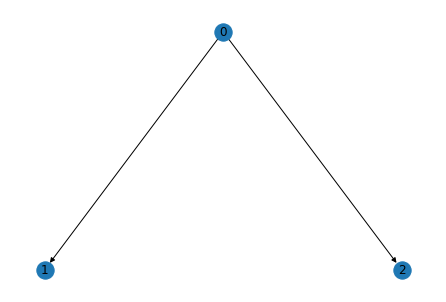

In [24]:
# Set up graph

if True:
    N = 10
    M = 3

    data_gen = MultiCategorical(N, M)
    data_gen.graph.B = np.array([
        [0, 0, 0],
        [1, 0, 0],
        [1, 0, 0]
    ])

if False:
    N = 10
    M = 2
    data_gen = MultiCategorical(N, M)
    data_gen.graph.B = np.array([
        [0, 0],
        [1, 0]
    ])

# Visualize
data_gen.graph.visualize()

In [25]:
# Choose model type to test pairwise binary connections

BINARY_MODEL_TYPE = CauseOnlyBinaryStructureModel
HYPOTHESIS_LIST = BINARY_MODEL_TYPE(N, M, 0, 1).hypotheses()

In [26]:
# Binary Test Training Constants
INNER_LR = 1e-1
OUTER_LR = 1e-2
TRANSFER_EPISODE_COUNT = 500
TRANSFER_EPISODE_GRADIENT_STEPS = 30
TRANSFER_EPISODE_BATCH_SIZE = 250
PRETRAIN_EPISODE_BATCH_SIZE = 500

# Notebook Constants
num_runs = 10
reset_edge_functions_between_runs = True # Whether or not each node pair and run gets differently sampled edge functions

In [27]:
# Iterate through all node pairs and save resulting predicted structures
node_pairs = []
for A in range(M - 1):
    for B in range(A + 1, M):
        node_pairs.append((A, B))

structure_predictions = {} # {NodePair -> {Hypothesis -> float}}
structure_training_curves = {} # {NodePair -> {Hypothesis -> torch.FloatTensor(shape = (num_runs, transfer_episodes + 1))}}
for i in tnrange(len(node_pairs)):
    A, B = node_pairs[i]

    # Average structure results over multiple runs (same graph, same causal edge functions, newly sampled root functions)
    node_pair_predictions = {hypothesis: 0.0 for hypothesis in HYPOTHESIS_LIST}
    node_pair_training_curves = {hypothesis: torch.zeros(num_runs, TRANSFER_EPISODE_COUNT + 1).detach() for hypothesis in HYPOTHESIS_LIST}
    for run in tnrange(num_runs, leave=False):
        if reset_edge_functions_between_runs:
            data_gen.reset_all_distributions() # Keeps the graph, but changes function parametrizing effect nodes by cause nodes

        model = BINARY_MODEL_TYPE(N, M, A, B)
        model_handler = AugmentedBinaryModelTrainer(
            data_gen, model,
            inner_lr = INNER_LR,
            outer_lr = OUTER_LR,
            transfer_episode_count = TRANSFER_EPISODE_COUNT,
            transfer_episode_gradient_steps = TRANSFER_EPISODE_GRADIENT_STEPS,
            transfer_episode_batch_size = TRANSFER_EPISODE_BATCH_SIZE,
            pretrain_episode_batch_size = PRETRAIN_EPISODE_BATCH_SIZE
        )

        # Meta-learn structure
        model_handler.train_structure()

        # Save structure training curve
        for hyp_ind, hypothesis in enumerate(HYPOTHESIS_LIST):
            node_pair_training_curves[hypothesis][run, :] = model_handler.structure_likelihoods[:, hyp_ind]

        # Save final learned structure likelihood values
        for hypothesis, probability in zip(model.hypotheses(), model_handler.structure_likelihoods[-1].tolist()):
            node_pair_predictions[hypothesis] += probability / num_runs

    # Save resulting structure prediction
    structure_predictions[(A, B)] = node_pair_predictions
    structure_training_curves[(A, B)] = node_pair_training_curves

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [28]:
structure_predictions

{(0, 1): {<Hypothesis.FORWARD_CAUSE: 1>: 0.5881946444511414,
  <Hypothesis.BACKWARD_CAUSE: 2>: 0.4118053629994392},
 (0, 2): {<Hypothesis.FORWARD_CAUSE: 1>: 0.7250336498022081,
  <Hypothesis.BACKWARD_CAUSE: 2>: 0.27496636286377907},
 (1, 2): {<Hypothesis.FORWARD_CAUSE: 1>: 0.49579295217990876,
  <Hypothesis.BACKWARD_CAUSE: 2>: 0.5042070457711816}}

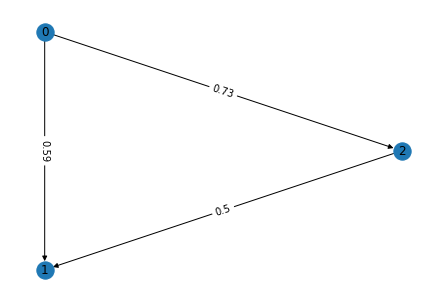

In [29]:
# Visualize graph resulting from these predictions
predicted_graph = nx.DiGraph()
for (A, B), binary_structure in structure_predictions.items():
    max_structure_prob = max(*binary_structure.values())
    if binary_structure[Hypothesis.FORWARD_CAUSE] == max_structure_prob:
        predicted_graph.add_edge(A, B, weight = round(binary_structure[Hypothesis.FORWARD_CAUSE], 2))
    elif binary_structure[Hypothesis.BACKWARD_CAUSE] == max_structure_prob:
        predicted_graph.add_edge(B, A, weight = round(binary_structure[Hypothesis.BACKWARD_CAUSE], 2))

pos = graphviz_layout(predicted_graph, prog='dot')
edge_labels = nx.get_edge_attributes(predicted_graph, 'weight')
nx.draw(predicted_graph, with_labels = True, pos = pos)
nx.draw_networkx_edge_labels(predicted_graph, pos, edge_labels = edge_labels)
plt.show()

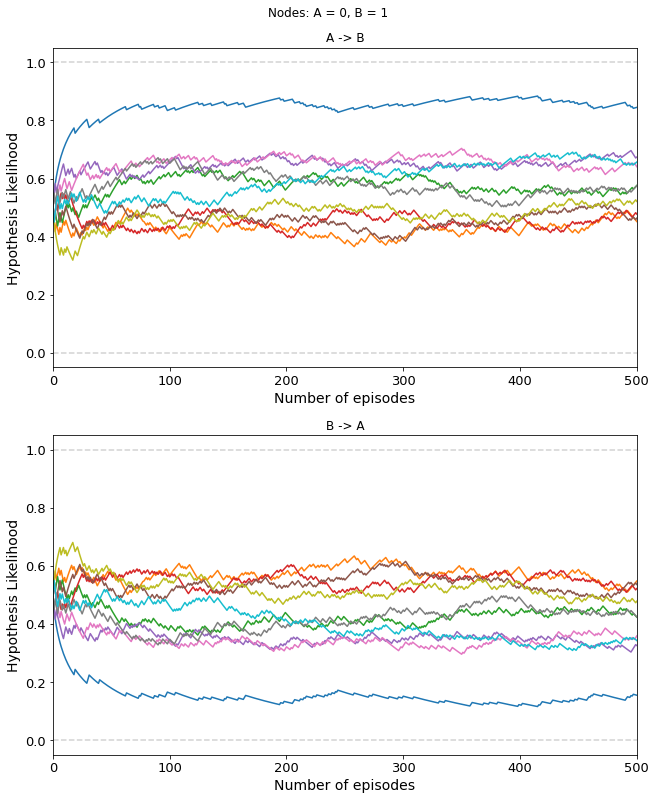

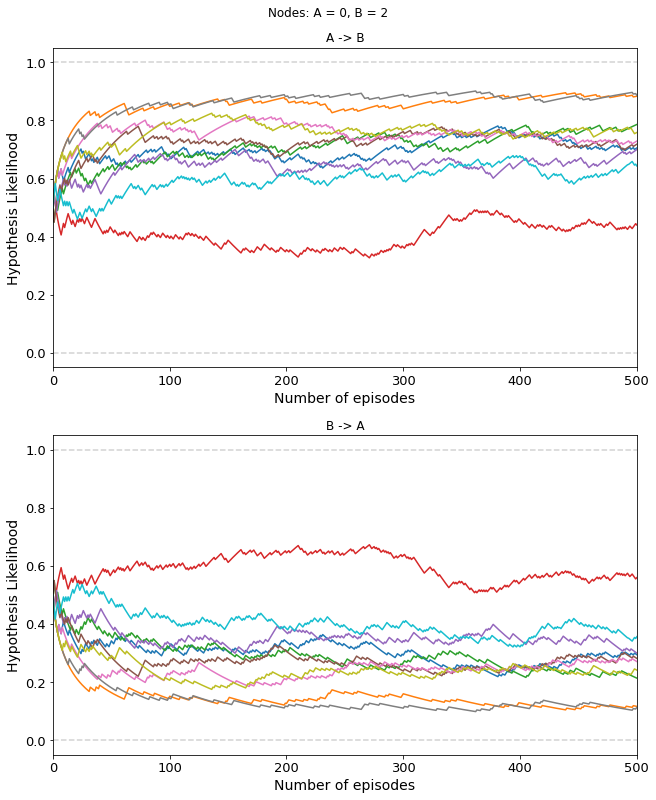

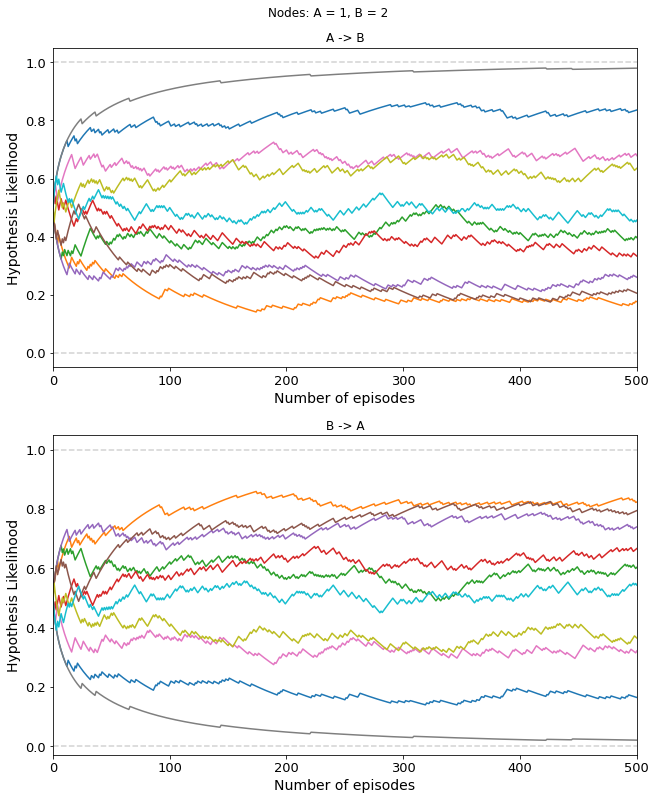

In [30]:
# Plot Training curves for each hypothesis and node pair
for A, B in node_pairs:
    fig, axarr = plt.subplots(len(HYPOTHESIS_LIST), 1, figsize=(9, 11), constrained_layout=True)
    fig.suptitle(f"Nodes: A = {A}, B = {B}")
    for i, hypothesis in enumerate(HYPOTHESIS_LIST):
        ax = axarr[i]
        ax.title.set_text(hypothesis.name())

        for run in range(num_runs):
            ax.plot(structure_training_curves[(A, B)][hypothesis][run].numpy())

        ax.tick_params(axis='both', which='major', labelsize=13)
        ax.axhline(1, c='lightgray', ls='--')
        ax.axhline(0, c='lightgray', ls='--')
        ax.set_xlim([0, TRANSFER_EPISODE_COUNT])
        ax.set_xlabel('Number of episodes', fontsize=14)
        ax.set_ylabel("Hypothesis Likelihood", fontsize=14)